In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00


In [ ]:
import torch


In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd

# Load the dataset
file_path = "/content/dataset_5.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()
import pandas as pd


file_path = '/content/authors.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data
import networkx as nx

# Constructing the graph as per the provided code, with a slight adjustment for this environment
G_with_concepts = nx.Graph()
merged_df = pd.merge(df[df['Publication Year'] <= 2018], data[['Author_id', 'Research Concepts']], left_on='Main Author ID', right_on='Author_id', how='left')
# Merging datasets with modifications to fit this environment's variable names

# Graph construction based on the provided logic
for i, row in merged_df.iterrows():
    if row['Main Author ID'] not in G_with_concepts:
        G_with_concepts.add_node(row['Main Author ID'],
                                 name=row['Author Name'],
                                 h_index=row['H-Index'],
                                 i_index=row['I-Index'],
                                 mean_citedness=row['Two-Year Mean Citedness'],
                                 institution=row['Institution'],
                                 country_code=row['Country Code'],
                                 research_concepts=row['Research Concepts'])
    if row['Co-Author ID'] not in G_with_concepts:
        G_with_concepts.add_node(row['Co-Author ID'], name=row['Co-Author Display Name'])
    if not G_with_concepts.has_edge(row['Main Author ID'], row['Co-Author ID']):
        G_with_concepts.add_edge(row['Main Author ID'], row['Co-Author ID'],
                                 publication_year=row['Publication Year'],
                                 avg_max_cited_by_percentile=row['Avg Max Cited By Percentile Year'],
                                 weight=row['Avg Max Cited By Percentile Year'])
    else:
        current_weight = G_with_concepts[row['Main Author ID']][row['Co-Author ID']].get('weight', 0)
        G_with_concepts[row['Main Author ID']][row['Co-Author ID']]['weight'] = current_weight + row['Avg Max Cited By Percentile Year']

# Basic information about the graph
graph_info = {
    'number_of_nodes': G_with_concepts.number_of_nodes(),
    'number_of_edges': G_with_concepts.number_of_edges()
}











# First, determine the complete set of node attributes
node_attributes = set()
for _, node_data in G_with_concepts.nodes(data=True):
    node_attributes.update(node_data.keys())

# Now, ensure every node has all the attributes, fill missing with None or a default value
for node, node_data in G_with_concepts.nodes(data=True):
    for attr in node_attributes:
        if attr not in node_data:
            # Assuming that setting the attribute to None or a default value is acceptable
            node_data[attr] = None  # or a suitable default value, e.g., 0 or ''

# After this preprocessing, you should be able to convert the graph to a Data object
from torch_geometric.utils.convert import from_networkx

# Now convert to a PyTorch Geometric Data objecta
data = from_networkx(G_with_concepts)

# Ensure that all node features are numerical for GNN processing
# This involves converting node features into a tensor. Let's use one-hot encoding as an example:

# For one-hot encoding, we create an identity matrix since we do not have actual features.
# Adjust this to use your real node features.
data.x = torch.eye(G_with_concepts.number_of_nodes())
# First, determine the complete set of node attributes

from torch_geometric.utils.convert import from_networkx



# Handling 'Research Concepts' to consider only top 50 most frequent concepts
all_concepts = merged_df['Research Concepts'].str.split(', ').explode().fillna('Unknown')
top_50_concepts = all_concepts.value_counts().nlargest(50).index.tolist()
filtered_concepts = merged_df['Research Concepts'].apply(lambda x: ', '.join([concept for concept in str(x).split(', ') if concept in top_50_concepts]))

# Prepare categorical data including filtered 'Research Concepts'
categorical_data = merged_df[['Country Code', 'Institution']].copy()
categorical_data.loc[:, 'Filtered Concepts'] = filtered_concepts.fillna('Unknown')

# Initialize OneHotEncoder with future-proof parameters
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical data
encoded_categorical_data = encoder.fit_transform(categorical_data)

# Calculate the total number of one-hot encoded features
encoded_feature_count = encoded_categorical_data.shape[1]

# Assuming numerical features are extracted and stored in 'numerical_features'
# Update numerical_features if not defined earlier
numerical_features = merged_df[['H-Index', 'I-Index', 'Two-Year Mean Citedness',
                                'Co-Author Counts', 'Sum Max Cited By Percentile Year', ]].fillna(0)
scaler = StandardScaler()
normalized_numerical_features = scaler.fit_transform(numerical_features)
encoded_feature_count = encoded_categorical_data.shape[1]
# Total number of node features
num_node_features = len(numerical_features.columns) + encoded_feature_count
num_node_features


# Combine all features into one matrix
node_features = np.hstack((normalized_numerical_features, encoded_categorical_data))
node_features_tensor = torch.tensor(node_features, dtype=torch.float)

edges = merged_df[['Main Author ID', 'Co-Author ID']].dropna()

# Convert author IDs to a categorical type, and get the corresponding category codes
# This ensures that nodes are represented as consecutive integers, which is often necessary
edges['Main Author ID'] = pd.Categorical(edges['Main Author ID']).codes
edges['Co-Author ID'] = pd.Categorical(edges['Co-Author ID']).codes

# Prepare edge_index as a tensor of shape [2, num_edges]
edge_index = torch.tensor(edges.values.T, dtype=torch.long)
# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(G_with_concepts)
data.x = node_features_tensor  # Assign node features
data.y = torch.randint(0, 2, (data.num_nodes,))  # Random labels for demonstration

# Adjust num_nodes to match the actual number of nodes in the graph
num_nodes = data.num_nodes

# Create train and test masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_indices, test_indices = train_test_split(np.arange(num_nodes), test_size=0.2)
train_mask[train_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Output verification
print("Graph Data:", data)
print("Number of nodes:", num_nodes)
print("Number of edges:", data.num_edges)
print("Feature matrix shape:", data.x.shape)
print("Size of train_mask:", train_mask.size())
assert train_mask.size(0) == num_nodes, "Corrected size of train_mask does not match the number of nodes"



Graph Data: Data(edge_index=[2, 13828], name=[3766], h_index=[3766], i_index=[3766], mean_citedness=[3766], institution=[3766], country_code=[3766], research_concepts=[3766], publication_year=[13828], avg_max_cited_by_percentile=[13828], weight=[13828], num_nodes=3766, x=[9013, 1493], y=[3766], train_mask=[3766], test_mask=[3766])
Number of nodes: 3766
Number of edges: 13828
Feature matrix shape: torch.Size([9013, 1493])
Size of train_mask: torch.Size([3766])


In [ ]:
data


Data(edge_index=[2, 18218], name=[4874], h_index=[4874], i_index=[4874], mean_citedness=[4874], institution=[4874], country_code=[4874], research_concepts=[4874], publication_year=[18218], avg_max_cited_by_percentile=[18218], weight=[18218], num_nodes=4874, x=[4874, 4874])

In [ ]:
df

,Main Author ID,Author Name,H-Index,I-Index,Two-Year Mean Citedness,Institution,Country Code,Publication Year,Co-Author ID,Co-Author Display Name,Co-Author Counts,Sum Max Cited By Percentile Year,Avg Max Cited By Percentile Year
0,A5087966779,Nediljko Budiša,45,147,4.095238,University of Manitoba,CA,1999,A5051064583,Caroline Minks,1,96.2,96.2
1,A5087966779,Nediljko Budiša,45,147,4.095238,University of Manitoba,CA,1999,A5001788395,Nediljko Budiša,1,96.2,96.2
2,A5087966779,Nediljko Budiša,45,147,4.095238,University of Manitoba,CA,1999,A5063495689,Robert Huber,2,182.8,91.4
3,A5087966779,Nediljko Budiša,45,147,4.095238,University of Manitoba,CA,1999,A5065468362,Waltraud Wenger,2,182.8,91.4
4,A5087966779,Nediljko Budiša,45,147,4.095238,University of Manitoba,CA,1999,A5039607051,Luis Moröder,1,96.2,96.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,A5092704975,Aureliano Bonsembiante,0,0,0.000000,Institute for Research in Biomedicine,ES,2023,A5045739288,Luís Filipe Costa Póvoas,1,87.5,87.5
13628,A5092704975,Aureliano Bonsembiante,0,0,0.000000,Institute for Research in Biomedicine,ES,2023,A5023079125,Bastiaan de Potter,1,87.5,87.5
13629,A5092704975,Aureliano Bonsembiante,0,0,0.000000,Institute for Research in Biomedicine,ES,2023,A5027826203,A. Pons,1,87.5,87.5
13630,A5092704975,Aureliano Bonsembiante,0,0,0.000000,Institute for Research in Biomedicine,ES,2023,A5068884244,F. Xavier Gomis‐Rüth,1,87.5,87.5


In [3]:
pip install torch-geometric --upgrade


In [154]:


import pandas as pd
import torch
import numpy as np
import networkx as nx
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
'''class GCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    def encode(self, x, edge_index):
        # Generate embeddings from the first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        return x
'''
'''import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
class EnhancedGCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedGCN, self).__init__()
        self.conv1 = GATConv(input_dim, 64, heads=4)
        self.conv2 = GATConv(64 * 4, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    def encode(self, x, edge_index):
        # Generate embeddings from the first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        return x
'''
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, LayerNorm

class AdvancedGAT(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedGAT, self).__init__()
        self.conv1 = GATConv(input_dim, 128, heads=4, dropout=0.1)
        self.norm1 = LayerNorm(128 * 4)
        self.conv2 = GATConv(128 * 4, 128, heads=4, concat=True, dropout=0.1)
        self.norm2 = LayerNorm(128 * 4)
        self.conv3 = GATConv(128 * 4, output_dim, heads=1, concat=False, dropout=0.1)
        self.norm3 = LayerNorm(output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.norm3(self.conv3(x, edge_index))
        return x

    def encode(self, x, edge_index):
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        return x


In [156]:
# Assuming `node_features_tensor` and `edge_index` are correctly defined
num_nodes = node_features_tensor.shape[0]  # Must match the number of nodes in your graph

# Create random labels for demonstration
labels = torch.randint(0, 2, (num_nodes,))

# Create train and test masks

train_mask = torch.rand(num_nodes) < 0.8  # 80% for training
test_mask = ~train_mask  # The remaining 20% for testing

'''model =EnhancedGAT(input_dim=node_features_tensor.shape[1], output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.MSELoss()
'''
model = AdvancedGAT(input_dim=node_features_tensor.shape[1], output_dim=2)  # Output 2 for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()


tg_data = Data(x=node_features_tensor, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)



In [157]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(tg_data)
    loss = criterion(out[tg_data.train_mask], tg_data.y[tg_data.train_mask])
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss {loss}')

def test():
    model.eval()
    with torch.no_grad():
        out = model(tg_data)
        pred = out.argmax(dim=1)
        correct = pred[tg_data.test_mask].eq(tg_data.y[tg_data.test_mask]).sum().item()
        acc = correct / int(tg_data.test_mask.sum())
        return acc

accuracy = test()
print(f'Test Accuracy: {accuracy}')



Epoch 0: Loss 0.9023941159248352
Epoch 10: Loss 0.7119185924530029
Epoch 20: Loss 0.6976324319839478
Epoch 30: Loss 0.6936650276184082
Epoch 40: Loss 0.6932111382484436
Epoch 50: Loss 0.6931964755058289
Epoch 60: Loss 0.6927523016929626
Epoch 70: Loss 0.6927186250686646
Epoch 80: Loss 0.6927245259284973
Epoch 90: Loss 0.6921353340148926
Epoch 100: Loss 0.6918321251869202
Epoch 110: Loss 0.6917021870613098
Epoch 120: Loss 0.6911452412605286
Epoch 130: Loss 0.6909905672073364
Epoch 140: Loss 0.6905139684677124
Epoch 150: Loss 0.6892054080963135
Epoch 160: Loss 0.6888892650604248
Epoch 170: Loss 0.686133086681366
Epoch 180: Loss 0.6841785311698914
Epoch 190: Loss 0.6820926070213318
Test Accuracy: 0.4917771883289125


In [ ]:
'''import torch
from sklearn.metrics.pairwise import cosine_similarity

def recommend_co_authors(author_id, author_to_index, all_embeddings, top_k=5):
    # Get the index of the author from the author ID
    if author_id not in author_to_index:
        return "Author ID not found"
    author_idx = author_to_index[author_id]

    # Compute the cosine similarity between the author's embedding and all other embeddings
    author_embedding = all_embeddings[author_idx].unsqueeze(0)  # Reshape for similarity computation
    similarity_scores = cosine_similarity(author_embedding, all_embeddings.numpy())[0]

    # Create a mask to exclude the author themselves from the recommendations
    similarity_scores[author_idx] = -1

    # Find the indices of the top k similar authors
    top_indices = torch.argsort(torch.from_numpy(similarity_scores), descending=True)[:top_k]

    # Convert indices back to author IDs
    index_to_author = {idx: id for id, idx in author_to_index.items()}
    recommended_authors = [index_to_author[idx.item()] for idx in top_indices]

    return recommended_authors

# Create a mapping from author ID to index based on the order in your graph nodes
author_to_index = {author_id: idx for idx, author_id in enumerate(G_with_concepts.nodes())}

# Example usage: Assuming 'A5066812402' is a valid author ID in your graph
recommended_authors = recommend_co_authors('A5066812402', author_to_index, all_embeddings, top_k=200)
print("Recommended Co-authors for Author A5066812402:", recommended_authors)


In [158]:
# Prepare the model for inference
model.eval()  # Switch to evaluation mode to disable dropout

# Assuming data_2023 is already a PyTorch Geometric Data object and suitable for model input
with torch.no_grad():
    embeddings_2023 = model.encode(data.x, data.edge_index)  # Generate embeddings using the encode method

# Calculate similarity scores between all node pairs using dot product
similarity_matrix = torch.mm(embeddings_2023, embeddings_2023.t())
similarity_scores = similarity_matrix.cpu().numpy()  # Move to CPU for numpy operations


In [159]:
# Get existing edges to filter them out from predictions
existing_edges = set([(min(u, v), max(u, v)) for u, v in data.edge_index.t().tolist()])

# Generate and rank predicted edges based on similarity scores
predicted_edges = []
num_nodes = data.num_nodes  # This gives the total number of nodes in your data object

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Ensure i < j to avoid duplicate pairs
        if (i, j) not in existing_edges and (j, i) not in existing_edges:
            predicted_edges.append((i, j, similarity_scores[i, j]))

# Sort predicted edges by their scores, in descending order
predicted_edges.sort(key=lambda x: x[2], reverse=True)

# Print the top 100 predicted edges with their scores
# print("Top 100 Predicted Edges:")
# for edge in predicted_edges[:100]:
#     print(f"Edge between node {edge[0]} and node {edge[1]} with similarity score {edge[2]:.3f}")


In [160]:
print("Top 100 Predicted Edges:")
for edge in predicted_edges[:100]:
  print(f"Edge between node {edge[0]} and node {edge[1]} with similarity score {edge[2]:.3f}")



Top 100 Predicted Edges:
Edge between node 190 and node 196 with similarity score 11546.783
Edge between node 171 and node 190 with similarity score 11537.682
Edge between node 171 and node 194 with similarity score 11537.580
Edge between node 171 and node 195 with similarity score 11537.580
Edge between node 171 and node 196 with similarity score 11537.426
Edge between node 164 and node 190 with similarity score 11533.729
Edge between node 164 and node 195 with similarity score 11533.629
Edge between node 164 and node 194 with similarity score 11533.627
Edge between node 164 and node 196 with similarity score 11533.473
Edge between node 183 and node 190 with similarity score 11527.581
Edge between node 183 and node 194 with similarity score 11527.480
Edge between node 183 and node 195 with similarity score 11527.480
Edge between node 183 and node 196 with similarity score 11527.326
Edge between node 164 and node 171 with similarity score 11524.548
Edge between node 153 and node 190 wi

In [161]:
# Example code to construct the graph and create the mapping
import networkx as nx

G = nx.Graph()
index_to_author_id = {}  # Dictionary to map indices to author IDs

for idx, row in df.iterrows():
    author_id = row['Main Author ID']
    if author_id not in G:
        index = len(G)
        G.add_node(author_id)
        index_to_author_id[index] = author_id  # Map the current index to the author ID

    co_author_id = row['Co-Author ID']
    if co_author_id not in G:
        index = len(G)
        G.add_node(co_author_id)
        index_to_author_id[index] = co_author_id  # Do the same for the co-author

    # Add or update edges as appropriate
    G.add_edge(author_id, co_author_id, weight=row.get('Citation', 1))


In [162]:
# Assuming similarity_scores and existing_edges have been set up as previously discussed

predicted_edges = []
num_nodes = len(G_with_concepts.nodes)  # Update to reflect using graph nodes directly

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Ensure i < j to avoid duplicate pairs
        if (i, j) not in existing_edges and (j, i) not in existing_edges:
            # Map indices back to author IDs for output
            author_id_i = index_to_author_id[i]
            author_id_j = index_to_author_id[j]
            predicted_edges.append((author_id_i, author_id_j, similarity_scores[i, j]))

# Sort predicted edges by their scores in descending order
predicted_edges.sort(key=lambda x: x[2], reverse=True)

# Print the top 100 predicted edges with their scores
print("Top 100 Predicted Edges:")
for edge in predicted_edges[:100]:
    print(f"Edge between author {edge[0]} and author {edge[1]} with similarity score {edge[2]:.3f}")


Top 100 Predicted Edges:
Edge between author A5046017741 and author A5024966463 with similarity score 11546.783
Edge between author A5013562042 and author A5046017741 with similarity score 11537.682
Edge between author A5013562042 and author A5072383579 with similarity score 11537.580
Edge between author A5013562042 and author A5068079731 with similarity score 11537.580
Edge between author A5013562042 and author A5024966463 with similarity score 11537.426
Edge between author A5066663559 and author A5046017741 with similarity score 11533.729
Edge between author A5066663559 and author A5068079731 with similarity score 11533.629
Edge between author A5066663559 and author A5072383579 with similarity score 11533.627
Edge between author A5066663559 and author A5024966463 with similarity score 11533.473
Edge between author A5065595809 and author A5046017741 with similarity score 11527.581
Edge between author A5065595809 and author A5072383579 with similarity score 11527.480
Edge between autho

In [163]:
import networkx as nx
import pandas as pd

# Assuming df is your DataFrame and already loaded
data_combined_years = df[(df['Publication Year'] == 2019)|(df['Publication Year'] == 2020)|(df['Publication Year'] == 2021)|(df['Publication Year'] == 2022)|(df['Publication Year'] == 2023)]

# Create a mapping from index to author ID if not already created
index_to_author_id = {index: node for index, node in enumerate(G_with_concepts.nodes())}

# Assuming similarity_scores and existing_edges have been set up as previously discussed
predicted_edges = []
num_nodes = len(G_with_concepts.nodes)  # This gives the total number of nodes in your graph

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Ensure i < j to avoid duplicate pairs
        if (i, j) not in existing_edges and (j, i) not in existing_edges:
            author_id_i = index_to_author_id[i]
            author_id_j = index_to_author_id[j]
            predicted_edges.append((author_id_i, author_id_j, similarity_scores[i, j]))

# Sort predicted edges by their scores in descending order
predicted_edges.sort(key=lambda x: x[2], reverse=True)

# Print the top 100 predicted edges with their scores
print("Top 100 Predicted Edges:")
for edge in predicted_edges[:100]:
    print(f"Edge between author {edge[0]} and author {edge[1]} with similarity score {edge[2]:.3f}")

# Convert 2023 collaborations to a set of tuples for easier comparison
actual_2023_edges = set((row['Main Author ID'], row['Co-Author ID']) for index, row in data_combined_years.iterrows())

# Since our prediction does not consider the direction of collaboration, we need to check both possible orders
matches = [(u, v, score) for u, v, score in predicted_edges if (u, v) in actual_2023_edges or (v, u) in actual_2023_edges]

# Display the matches
print("Number of matches found:", len(matches))
for match in matches:
    print("Matched edge:", match)


Top 100 Predicted Edges:
Edge between author A5066564703 and author A5082408024 with similarity score 11546.783
Edge between author A5061586847 and author A5066564703 with similarity score 11537.682
Edge between author A5061586847 and author A5002049126 with similarity score 11537.580
Edge between author A5061586847 and author A5038811216 with similarity score 11537.580
Edge between author A5061586847 and author A5082408024 with similarity score 11537.426
Edge between author A5074704114 and author A5066564703 with similarity score 11533.729
Edge between author A5074704114 and author A5038811216 with similarity score 11533.629
Edge between author A5074704114 and author A5002049126 with similarity score 11533.627
Edge between author A5074704114 and author A5082408024 with similarity score 11533.473
Edge between author A5035948498 and author A5066564703 with similarity score 11527.581
Edge between author A5035948498 and author A5002049126 with similarity score 11527.480
Edge between autho

# ZSCORE NORMALIZATION

In [140]:
from scipy.stats import zscore

# Provided list of matches with author pairs and scores

# Extract just the scores for z-score normalization
scores = np.array([match[2] for match in matches])

# Normalize the scores using z-score normalization
normalized_scores = zscore(scores)

# Combine the normalized scores back with the author pairs
normalized_matches_zscore = [(match[0], match[1], score) for match, score in zip(matches, normalized_scores)]

# Display the normalized matches
normalized_matches_zscore


[('A5002259164', 'A5082408024', 4.759807),
 ('A5003365197', 'A5044702420', 3.4479513),
 ('A5029103757', 'A5044702420', 3.4208727),
 ('A5019421146', 'A5044702420', 3.3639553),
 ('A5061124639', 'A5044702420', 3.1372905),
 ('A5040732268', 'A5071677632', 1.4770994),
 ('A5058235831', 'A5071677632', 1.466944),
 ('A5010745506', 'A5071677632', 1.4647892),
 ('A5087966779', 'A5071677632', 1.4637015),
 ('A5020569558', 'A5071677632', 1.460076),
 ('A5087821813', 'A5071677632', 1.4593586),
 ('A5088264372', 'A5071677632', 1.4522282),
 ('A5087966779', 'A5024558707', 0.635389),
 ('A5044699527', 'A5040800580', 0.40873018),
 ('A5044699527', 'A5026963102', 0.40421632),
 ('A5056664497', 'A5002137780', 0.22415183),
 ('A5056664497', 'A5032238382', 0.22249359),
 ('A5002137780', 'A5008798147', -0.31766143),
 ('A5076844877', 'A5071677632', -0.3255994),
 ('A5087966779', 'A5074342461', -0.3443368),
 ('A5003365197', 'A5085495473', -0.36609694),
 ('A5044702420', 'A5085495473', -0.36666945),
 ('A5077915220', 'A50854

In [141]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the normalized scores
sigmoid_scores = sigmoid(normalized_scores)

# Combine the sigmoid scores back with the author pairs
sigmoid_matches = [(match[0], match[1], score) for match, score in zip(matches, sigmoid_scores)]

# Display the matches with sigmoid scores
sigmoid_matches


[('A5002259164', 'A5082408024', 0.99150556),
 ('A5003365197', 'A5044702420', 0.96917),
 ('A5029103757', 'A5044702420', 0.9683506),
 ('A5019421146', 'A5044702420', 0.9665589),
 ('A5061124639', 'A5044702420', 0.95840496),
 ('A5040732268', 'A5071677632', 0.81413406),
 ('A5058235831', 'A5071677632', 0.81259245),
 ('A5010745506', 'A5071677632', 0.8122641),
 ('A5087966779', 'A5071677632', 0.8120982),
 ('A5020569558', 'A5071677632', 0.8115443),
 ('A5087821813', 'A5071677632', 0.81143457),
 ('A5088264372', 'A5071677632', 0.81034106),
 ('A5087966779', 'A5024558707', 0.6537104),
 ('A5044699527', 'A5040800580', 0.60078335),
 ('A5044699527', 'A5026963102', 0.5997002),
 ('A5056664497', 'A5002137780', 0.5558045),
 ('A5056664497', 'A5032238382', 0.55539507),
 ('A5002137780', 'A5008798147', 0.4212458),
 ('A5076844877', 'A5071677632', 0.41931173),
 ('A5087966779', 'A5074342461', 0.4147564),
 ('A5003365197', 'A5085495473', 0.40948448),
 ('A5044702420', 'A5085495473', 0.40934604),
 ('A5077915220', 'A5085

In [142]:
# The final_normalized_scores provided earlier will be used in the given code snippet
formatted_output = [
    f"Edge between author {author1} and author {author2} with normalized similarity score {score:.3f}"
    for author1, author2, score in sigmoid_matches
]

# Execute the print statements and print the length of the normalized_matches
for output in formatted_output:
    print(output)

# Print the number of matches


Edge between author A5002259164 and author A5082408024 with normalized similarity score 0.992
Edge between author A5003365197 and author A5044702420 with normalized similarity score 0.969
Edge between author A5029103757 and author A5044702420 with normalized similarity score 0.968
Edge between author A5019421146 and author A5044702420 with normalized similarity score 0.967
Edge between author A5061124639 and author A5044702420 with normalized similarity score 0.958
Edge between author A5040732268 and author A5071677632 with normalized similarity score 0.814
Edge between author A5058235831 and author A5071677632 with normalized similarity score 0.813
Edge between author A5010745506 and author A5071677632 with normalized similarity score 0.812
Edge between author A5087966779 and author A5071677632 with normalized similarity score 0.812
Edge between author A5020569558 and author A5071677632 with normalized similarity score 0.812
Edge between author A5087821813 and author A5071677632 with 

In [143]:
import pandas as pd

# Placeholder for loading your dataset
dataset = pd.read_csv('/content/dataset_5.csv')

def calculate_avg_max_cited_by_percentile_year(author_pairs, dataset):
    avg_max_cited_by_percentile_year_list = []

    for main_author_id, co_author_id in author_pairs:
        # Filter dataset for the specific main author and co-author pair
        filtered_dataset = dataset[((dataset['Main Author ID'] == main_author_id) &
                                    (dataset['Co-Author ID'] == co_author_id)) |
                                   ((dataset['Main Author ID'] == co_author_id) &
                                    (dataset['Co-Author ID'] == main_author_id))]

        # Directly get the 'Co-Author Counts' or the intended metric without averaging if it's a single value per pair
        # If 'Co-Author Counts' is meant to be averaged across multiple rows, uncomment the mean calculation line
        # avg_max_cited_by_percentile_year = filtered_dataset['Co-Author Counts'].mean()
        avg_max_cited_by_percentile_year = filtered_dataset['Avg Max Cited By Percentile Year'].mean()

        # Append the result to the list along with the author pair
        avg_max_cited_by_percentile_year_list.append((main_author_id, co_author_id, avg_max_cited_by_percentile_year))

    return avg_max_cited_by_percentile_year_list

# Assuming 'matches' is defined and contains pairs of author IDs
author_pairs = [(match[0], match[1]) for match in sigmoid_matches]

# Execute the function with the author_pairs and the loaded dataset
# Uncomment and adjust the dataset path as necessary
author_pairs_avg = calculate_avg_max_cited_by_percentile_year(author_pairs, dataset)
author_pairs_avg, len(author_pairs_avg)


([('A5002259164', 'A5082408024', 66.4),
  ('A5003365197', 'A5044702420', 99.9),
  ('A5029103757', 'A5044702420', 100.0),
  ('A5019421146', 'A5044702420', 100.0),
  ('A5061124639', 'A5044702420', 100.0),
  ('A5040732268', 'A5071677632', 96.9),
  ('A5058235831', 'A5071677632', 96.6),
  ('A5010745506', 'A5071677632', 96.9),
  ('A5087966779', 'A5071677632', 96.75),
  ('A5020569558', 'A5071677632', 96.9),
  ('A5087821813', 'A5071677632', 96.6),
  ('A5088264372', 'A5071677632', 96.6),
  ('A5087966779', 'A5024558707', 87.5),
  ('A5044699527', 'A5040800580', 88.71904761666667),
  ('A5044699527', 'A5026963102', 82.0),
  ('A5056664497', 'A5002137780', 98.1),
  ('A5056664497', 'A5032238382', 98.1),
  ('A5002137780', 'A5008798147', 96.3),
  ('A5076844877', 'A5071677632', 96.9),
  ('A5087966779', 'A5074342461', 91.1),
  ('A5003365197', 'A5085495473', 100.0),
  ('A5044702420', 'A5085495473', 100.0),
  ('A5077915220', 'A5085495473', 99.46666666666665),
  ('A5079823537', 'A5085495473', 100.0),
  ('A50

In [144]:
scores = np.array([item[2] for item in author_pairs_avg])

# Perform z-score normalization
z_normalized_scores = zscore(scores)

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply sigmoid function to z-score normalized scores
sigmoid_scores = sigmoid(z_normalized_scores)

# Combine the author pairs with their normalized sigmoid scores
sigmoid_normalized_author_pairs = [
    (author_pairs_avg[i][0], author_pairs_avg[i][1], sigmoid_scores[i])
    for i in range(len(author_pairs_avg))
]

# Print out the normalized scores
for pair in sigmoid_normalized_author_pairs:
    print(f"Authors {pair[0]} and {pair[1]} have a normalized collaboration score of {pair[2]:.2f}")


Authors A5002259164 and A5082408024 have a normalized collaboration score of 0.01
Authors A5003365197 and A5044702420 have a normalized collaboration score of 0.73
Authors A5029103757 and A5044702420 have a normalized collaboration score of 0.73
Authors A5019421146 and A5044702420 have a normalized collaboration score of 0.73
Authors A5061124639 and A5044702420 have a normalized collaboration score of 0.73
Authors A5040732268 and A5071677632 have a normalized collaboration score of 0.62
Authors A5058235831 and A5071677632 have a normalized collaboration score of 0.60
Authors A5010745506 and A5071677632 have a normalized collaboration score of 0.62
Authors A5087966779 and A5071677632 have a normalized collaboration score of 0.61
Authors A5020569558 and A5071677632 have a normalized collaboration score of 0.62
Authors A5087821813 and A5071677632 have a normalized collaboration score of 0.60
Authors A5088264372 and A5071677632 have a normalized collaboration score of 0.60
Authors A5087966

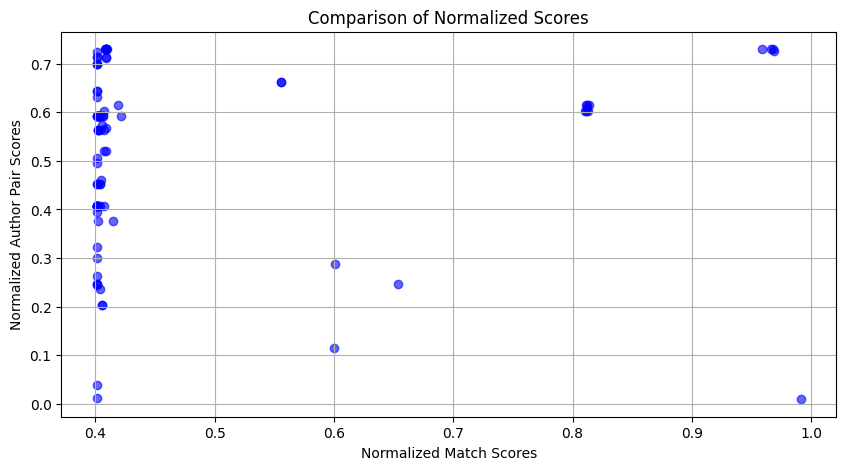

In [145]:
import matplotlib.pyplot as plt

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in sigmoid_matches]
normalized_author_pair_scores = [pair[2] for pair in sigmoid_normalized_author_pairs]

# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Create a scatter plot to visualize the comparison
plt.figure(figsize=(10, 5))
plt.scatter(normalized_match_scores, normalized_author_pair_scores, alpha=0.6, color='blue')
plt.title('Comparison of Normalized Scores')
plt.xlabel('Normalized Match Scores')
plt.ylabel('Normalized Author Pair Scores')
plt.grid(True)
plt.show()


In [147]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in sigmoid_matches]
normalized_author_pair_scores = [pair[2] for pair in sigmoid_normalized_author_pairs]

# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(normalized_match_scores, normalized_author_pair_scores))

print(f"The RMSE between the two sets of normalized scores is: {rmse:.4f}")


The RMSE between the two sets of normalized scores is: 0.2298


# MINMAX


In [148]:

filtered_matches = [(u, v, score) for u, v, score in matches  ]
filtered_matches, len(filtered_matches)

([('A5002259164', 'A5082408024', 4005.1667),
  ('A5003365197', 'A5044702420', 2987.0947),
  ('A5029103757', 'A5044702420', 2966.08),
  ('A5019421146', 'A5044702420', 2921.9092),
  ('A5061124639', 'A5044702420', 2746.005),
  ('A5040732268', 'A5071677632', 1457.6058),
  ('A5058235831', 'A5071677632', 1449.7246),
  ('A5010745506', 'A5071677632', 1448.0524),
  ('A5087966779', 'A5071677632', 1447.2083),
  ('A5020569558', 'A5071677632', 1444.3947),
  ('A5087821813', 'A5071677632', 1443.8379),
  ('A5088264372', 'A5071677632', 1438.3043),
  ('A5087966779', 'A5024558707', 804.3924),
  ('A5044699527', 'A5040800580', 628.49274),
  ('A5044699527', 'A5026963102', 624.98975),
  ('A5056664497', 'A5002137780', 485.24985),
  ('A5056664497', 'A5032238382', 483.96295),
  ('A5002137780', 'A5008798147', 64.77306),
  ('A5076844877', 'A5071677632', 58.612793),
  ('A5087966779', 'A5074342461', 44.07154),
  ('A5003365197', 'A5085495473', 27.184479),
  ('A5044702420', 'A5085495473', 26.740177),
  ('A5077915220'

In [149]:
# Assume filtered_matches contains the matches with similarity scoresta

# Extract only the similarity scores from the filtered matches
similarity_scores = [score for u, v, score in filtered_matches]

# Perform min-max normalization on the similarity scores
min_score = min(similarity_scores)
max_score = max(similarity_scores)

# Avoid division by zero in case min_score == max_score
if min_score == max_score:
    normalized_scores = [1 if score == max_score else 0 for score in similarity_scores]
else:
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in similarity_scores]

# Combine the author IDs with the normalized scores
normalized_matches = [(*filtered_matches[i][:2], normalized_scores[i]) for i in range(len(filtered_matches))]

# Display the normalized matches
print("Normalized Matches:")
for match in normalized_matches:
    print(f"Edge between author {match[0]} and author {match[1]} with normalized similarity score {match[2]:.3f}")
print(len(normalized_matches))

Normalized Matches:
Edge between author A5002259164 and author A5082408024 with normalized similarity score 1.000
Edge between author A5003365197 and author A5044702420 with normalized similarity score 0.746
Edge between author A5029103757 and author A5044702420 with normalized similarity score 0.741
Edge between author A5019421146 and author A5044702420 with normalized similarity score 0.730
Edge between author A5061124639 and author A5044702420 with normalized similarity score 0.686
Edge between author A5040732268 and author A5071677632 with normalized similarity score 0.364
Edge between author A5058235831 and author A5071677632 with normalized similarity score 0.362
Edge between author A5010745506 and author A5071677632 with normalized similarity score 0.362
Edge between author A5087966779 and author A5071677632 with normalized similarity score 0.361
Edge between author A5020569558 and author A5071677632 with normalized similarity score 0.361
Edge between author A5087821813 and auth

In [150]:
import pandas as pd

# Placeholder for loading your dataset
dataset = pd.read_csv('/content/dataset_5.csv')

def calculate_avg_max_cited_by_percentile_year(author_pairs, dataset):
    avg_max_cited_by_percentile_year_list = []

    for main_author_id, co_author_id in author_pairs:
        # Filter dataset for the specific main author and co-author pair
        filtered_dataset = dataset[((dataset['Main Author ID'] == main_author_id) &
                                    (dataset['Co-Author ID'] == co_author_id)) |
                                   ((dataset['Main Author ID'] == co_author_id) &
                                    (dataset['Co-Author ID'] == main_author_id))]

        # Directly get the 'Co-Author Counts' or the intended metric without averaging if it's a single value per pair
        # If 'Co-Author Counts' is meant to be averaged across multiple rows, uncomment the mean calculation line
        # avg_max_cited_by_percentile_year = filtered_dataset['Co-Author Counts'].mean()
        avg_max_cited_by_percentile_year = filtered_dataset['Avg Max Cited By Percentile Year'].mean()

        # Append the result to the list along with the author pair
        avg_max_cited_by_percentile_year_list.append((main_author_id, co_author_id, avg_max_cited_by_percentile_year))

    return avg_max_cited_by_percentile_year_list

# Assuming 'matches' is defined and contains pairs of author IDs
author_pairs = [(match[0], match[1]) for match in filtered_matches]

# Execute the function with the author_pairs and the loaded dataset
# Uncomment and adjust the dataset path as necessary
author_pairs_avg = calculate_avg_max_cited_by_percentile_year(author_pairs, dataset)
author_pairs_avg, len(author_pairs_avg)


([('A5002259164', 'A5082408024', 66.4),
  ('A5003365197', 'A5044702420', 99.9),
  ('A5029103757', 'A5044702420', 100.0),
  ('A5019421146', 'A5044702420', 100.0),
  ('A5061124639', 'A5044702420', 100.0),
  ('A5040732268', 'A5071677632', 96.9),
  ('A5058235831', 'A5071677632', 96.6),
  ('A5010745506', 'A5071677632', 96.9),
  ('A5087966779', 'A5071677632', 96.75),
  ('A5020569558', 'A5071677632', 96.9),
  ('A5087821813', 'A5071677632', 96.6),
  ('A5088264372', 'A5071677632', 96.6),
  ('A5087966779', 'A5024558707', 87.5),
  ('A5044699527', 'A5040800580', 88.71904761666667),
  ('A5044699527', 'A5026963102', 82.0),
  ('A5056664497', 'A5002137780', 98.1),
  ('A5056664497', 'A5032238382', 98.1),
  ('A5002137780', 'A5008798147', 96.3),
  ('A5076844877', 'A5071677632', 96.9),
  ('A5087966779', 'A5074342461', 91.1),
  ('A5003365197', 'A5085495473', 100.0),
  ('A5044702420', 'A5085495473', 100.0),
  ('A5077915220', 'A5085495473', 99.46666666666665),
  ('A5079823537', 'A5085495473', 100.0),
  ('A50

In [151]:
from sklearn.preprocessing import MinMaxScaler

# Extract the scores from the list of author pairs
scores = np.array([item[2] for item in author_pairs_avg]).reshape(-1, 1)

# Create a Min-Max scaler instance
scaler = MinMaxScaler()

# Fit the scaler to the scores and transform the scores to the range [0, 1]
minmax_normalized_scores = scaler.fit_transform(scores).flatten()

# Combine the author pairs with their min-max normalized scores
minmax_normalized_author_pairs = [
    (author_pairs_avg[i][0], author_pairs_avg[i][1], minmax_normalized_scores[i])
    for i in range(len(author_pairs_avg))
]

# Print out the min-max normalized scores
for pair in minmax_normalized_author_pairs:
    print(f"Authors {pair[0]} and {pair[1]} have a normalized collaboration score of {pair[2]:.2f}")

Authors A5002259164 and A5082408024 have a normalized collaboration score of 0.00
Authors A5003365197 and A5044702420 have a normalized collaboration score of 1.00
Authors A5029103757 and A5044702420 have a normalized collaboration score of 1.00
Authors A5019421146 and A5044702420 have a normalized collaboration score of 1.00
Authors A5061124639 and A5044702420 have a normalized collaboration score of 1.00
Authors A5040732268 and A5071677632 have a normalized collaboration score of 0.91
Authors A5058235831 and A5071677632 have a normalized collaboration score of 0.90
Authors A5010745506 and A5071677632 have a normalized collaboration score of 0.91
Authors A5087966779 and A5071677632 have a normalized collaboration score of 0.90
Authors A5020569558 and A5071677632 have a normalized collaboration score of 0.91
Authors A5087821813 and A5071677632 have a normalized collaboration score of 0.90
Authors A5088264372 and A5071677632 have a normalized collaboration score of 0.90
Authors A5087966

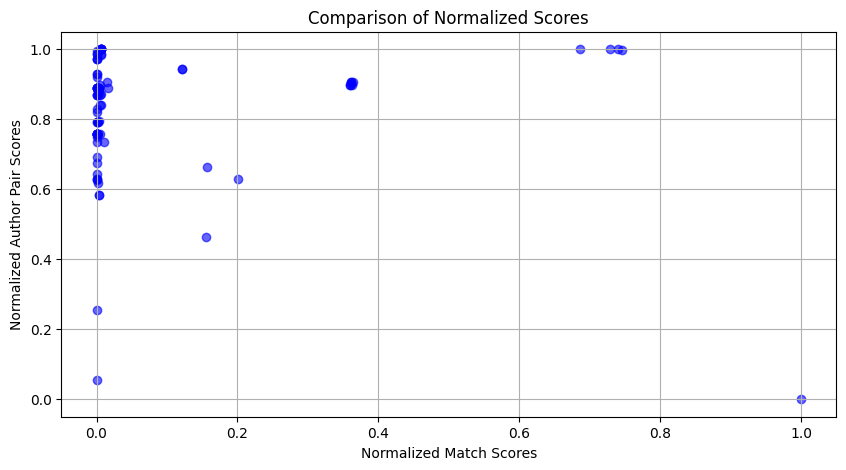

In [152]:
import matplotlib.pyplot as plt

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in normalized_matches]
normalized_author_pair_scores = [pair[2] for pair in minmax_normalized_author_pairs]

# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Create a scatter plot to visualize the comparison
plt.figure(figsize=(10, 5))
plt.scatter(normalized_match_scores, normalized_author_pair_scores, alpha=0.6, color='blue')
plt.title('Comparison of Normalized Scores')
plt.xlabel('Normalized Match Scores')
plt.ylabel('Normalized Author Pair Scores')
plt.grid(True)
plt.show()


In [153]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in normalized_matches]
normalized_author_pair_scores = [pair[2] for pair in minmax_normalized_author_pairs]
# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(normalized_match_scores, normalized_author_pair_scores))

print(f"The RMSE between the two sets of normalized scores is: {rmse:.4f}")


The RMSE between the two sets of normalized scores is: 0.7941


# PARAMETRIC SCALING

In [105]:
from scipy.stats import boxcox

In [106]:
# Extract just the scores
scores = np.array([match[2] for match in matches])

# Shift scores to be strictly positive (Box-Cox requires positive values)
scores_shifted = scores + (1 - scores.min()) if scores.min() <= 0 else scores

# Apply the Box-Cox transformation
transformed_scores, _ = boxcox(scores_shifted)

# Scaling the Box-Cox transformed values to the range [0, 1]
min_value = transformed_scores.min()
max_value = transformed_scores.max()
scaled_transformed_scores = (transformed_scores - min_value) / (max_value - min_value)

# Combine the scaled scores back with the author pairs
scaled_matches_boxcox = [(match[0], match[1], score) for match, score in zip(matches, scaled_transformed_scores)]

# Display the scaled matches using Box-Cox transformation
scaled_matches_boxcox

[('A5002259164', 'A5082408024', 1.0),
 ('A5029103757', 'A5044702420', 0.9993242),
 ('A5003365197', 'A5044702420', 0.99916035),
 ('A5019421146', 'A5044702420', 0.9990152),
 ('A5061124639', 'A5044702420', 0.9984248),
 ('A5056664497', 'A5002137780', 0.9829449),
 ('A5056664497', 'A5032238382', 0.9813361),
 ('A5040732268', 'A5071677632', 0.9791103),
 ('A5020569558', 'A5071677632', 0.97895426),
 ('A5087966779', 'A5071677632', 0.97895133),
 ('A5010745506', 'A5071677632', 0.97894335),
 ('A5058235831', 'A5071677632', 0.97892916),
 ('A5088264372', 'A5071677632', 0.978873),
 ('A5087821813', 'A5071677632', 0.9788582),
 ('A5087966779', 'A5024558707', 0.9689534),
 ('A5044699527', 'A5040800580', 0.95848674),
 ('A5044699527', 'A5026963102', 0.95848405),
 ('A5089317388', 'A5018416560', 0.83015347),
 ('A5087966779', 'A5074342461', 0.80912876),
 ('A5074342461', 'A5002137780', 0.72155756),
 ('A5040428156', 'A5002137780', 0.7164601),
 ('A5071164210', 'A5025432010', 0.62859017),
 ('A5029224175', 'A501841656

In [107]:
# The final_normalized_scores provided earlier will be used in the given code snippet
formatted_output_PS = [
    f"Edge between author {author1} and author {author2} with normalized similarity score {score:.3f}"
    for author1, author2, score in scaled_matches_boxcox
]

# Execute the print statements and print the length of the normalized_matches
for output in formatted_output_PS:
    print(output)

# Print the number of matches
len(formatted_output_PS)

Edge between author A5002259164 and author A5082408024 with normalized similarity score 1.000
Edge between author A5029103757 and author A5044702420 with normalized similarity score 0.999
Edge between author A5003365197 and author A5044702420 with normalized similarity score 0.999
Edge between author A5019421146 and author A5044702420 with normalized similarity score 0.999
Edge between author A5061124639 and author A5044702420 with normalized similarity score 0.998
Edge between author A5056664497 and author A5002137780 with normalized similarity score 0.983
Edge between author A5056664497 and author A5032238382 with normalized similarity score 0.981
Edge between author A5040732268 and author A5071677632 with normalized similarity score 0.979
Edge between author A5020569558 and author A5071677632 with normalized similarity score 0.979
Edge between author A5087966779 and author A5071677632 with normalized similarity score 0.979
Edge between author A5010745506 and author A5071677632 with 

95

In [108]:
import pandas as pd

# Placeholder for loading your dataset
dataset = pd.read_csv('/content/dataset_5.csv')

def calculate_avg_max_cited_by_percentile_year(author_pairs, dataset):
    avg_max_cited_by_percentile_year_list = []

    for main_author_id, co_author_id in author_pairs:
        # Filter dataset for the specific main author and co-author pair
        filtered_dataset = dataset[((dataset['Main Author ID'] == main_author_id) &
                                    (dataset['Co-Author ID'] == co_author_id)) |
                                   ((dataset['Main Author ID'] == co_author_id) &
                                    (dataset['Co-Author ID'] == main_author_id))]

        # Directly get the 'Co-Author Counts' or the intended metric without averaging if it's a single value per pair
        # If 'Co-Author Counts' is meant to be averaged across multiple rows, uncomment the mean calculation line
        # avg_max_cited_by_percentile_year = filtered_dataset['Co-Author Counts'].mean()
        avg_max_cited_by_percentile_year = filtered_dataset['Avg Max Cited By Percentile Year'].mean()

        # Append the result to the list along with the author pair
        avg_max_cited_by_percentile_year_list.append((main_author_id, co_author_id, avg_max_cited_by_percentile_year))

    return avg_max_cited_by_percentile_year_list

# Assuming 'matches' is defined and contains pairs of author IDs
author_pairs = [(match[0], match[1]) for match in sigmoid_matches]

# Execute the function with the author_pairs and the loaded dataset
# Uncomment and adjust the dataset path as necessary
author_pairs_avg = calculate_avg_max_cited_by_percentile_year(author_pairs, dataset)
author_pairs_avg, len(author_pairs_avg)


([('A5002259164', 'A5082408024', 66.4),
  ('A5029103757', 'A5044702420', 100.0),
  ('A5003365197', 'A5044702420', 99.9),
  ('A5019421146', 'A5044702420', 100.0),
  ('A5061124639', 'A5044702420', 100.0),
  ('A5056664497', 'A5002137780', 98.1),
  ('A5056664497', 'A5032238382', 98.1),
  ('A5040732268', 'A5071677632', 96.9),
  ('A5020569558', 'A5071677632', 96.9),
  ('A5087966779', 'A5071677632', 96.75),
  ('A5010745506', 'A5071677632', 96.9),
  ('A5058235831', 'A5071677632', 96.6),
  ('A5088264372', 'A5071677632', 96.6),
  ('A5087821813', 'A5071677632', 96.6),
  ('A5087966779', 'A5024558707', 87.5),
  ('A5044699527', 'A5040800580', 88.71904761666667),
  ('A5044699527', 'A5026963102', 82.0),
  ('A5089317388', 'A5018416560', 94.0),
  ('A5087966779', 'A5074342461', 91.1),
  ('A5074342461', 'A5002137780', 96.3),
  ('A5040428156', 'A5002137780', 91.9),
  ('A5071164210', 'A5025432010', 99.5),
  ('A5029224175', 'A5018416560', 93.0),
  ('A5007769448', 'A5007702509', 89.1),
  ('A5060076105', 'A506

In [109]:
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler




scores = np.array([match[2] for match in author_pairs_avg])

# Shift scores to be strictly positive (Box-Cox requires positive values)
scores_shifted = scores + (1 - scores.min()) if scores.min() <= 0 else scores

# Apply the Box-Cox transformation
transformed_scores, _ = boxcox(scores_shifted)

# Scaling the Box-Cox transformed values to the range [0, 1]
min_value = transformed_scores.min()
max_value = transformed_scores.max()
scaled_transformed_scores_ac = (transformed_scores - min_value) / (max_value - min_value)

# Combine the scaled scores back with the author pairs
scaled_matches_boxcox_actual = [(match[0], match[1], score) for match, score in zip(matches, scaled_transformed_scores_ac)]

# Display the scaled matches using Box-Cox transformation
scaled_matches_boxcox_actual

[('A5002259164', 'A5082408024', 0.0),
 ('A5029103757', 'A5044702420', 1.0),
 ('A5003365197', 'A5044702420', 0.9895708506960891),
 ('A5019421146', 'A5044702420', 1.0),
 ('A5061124639', 'A5044702420', 1.0),
 ('A5056664497', 'A5002137780', 0.8176583059882548),
 ('A5056664497', 'A5032238382', 0.8176583059882548),
 ('A5040732268', 'A5071677632', 0.7183159853210119),
 ('A5020569558', 'A5071677632', 0.7183159853210119),
 ('A5087966779', 'A5071677632', 0.7066827585563846),
 ('A5010745506', 'A5071677632', 0.7183159853210119),
 ('A5058235831', 'A5071677632', 0.6952165084663143),
 ('A5088264372', 'A5071677632', 0.6952165084663143),
 ('A5087821813', 'A5071677632', 0.6952165084663143),
 ('A5087966779', 'A5024558707', 0.24082920931824836),
 ('A5044699527', 'A5040800580', 0.28008441964503583),
 ('A5044699527', 'A5026963102', 0.11596877392028265),
 ('A5089317388', 'A5018416560', 0.5209029675199898),
 ('A5087966779', 'A5074342461', 0.37281937243763713),
 ('A5074342461', 'A5002137780', 0.672776390646193

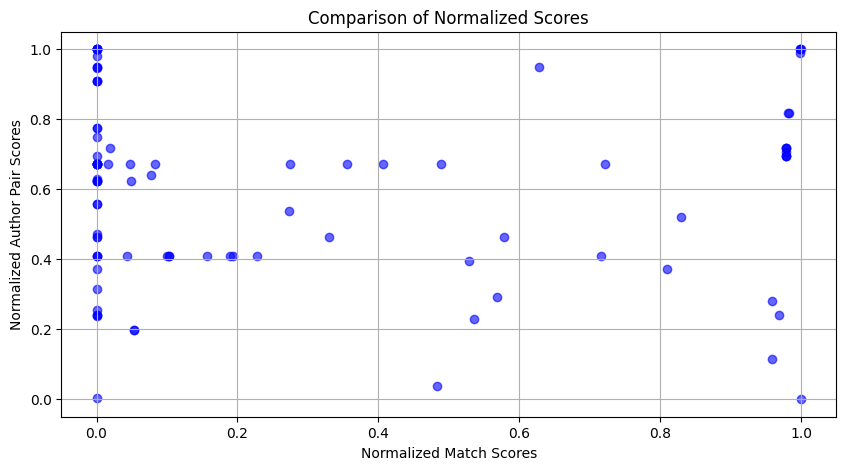

In [110]:
import matplotlib.pyplot as plt

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in scaled_matches_boxcox]
normalized_author_pair_scores = [pair[2] for pair in scaled_matches_boxcox_actual]

# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Create a scatter plot to visualize the comparison
plt.figure(figsize=(10, 5))
plt.scatter(normalized_match_scores, normalized_author_pair_scores, alpha=0.6, color='blue')
plt.title('Comparison of Normalized Scores')
plt.xlabel('Normalized Match Scores')
plt.ylabel('Normalized Author Pair Scores')
plt.grid(True)
plt.show()


In [111]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract scores from normalized_matches and normalized_author_pairs
# Assuming these are lists of tuples where the last element is the normalized score
normalized_match_scores = [match[2] for match in scaled_matches_boxcox]
normalized_author_pair_scores = [pair[2] for pair in scaled_matches_boxcox_actual]
# Ensuring both lists are of the same length for comparison
# This is just for example; you should adjust this logic based on actual data correlation needs
min_length = min(len(normalized_match_scores), len(normalized_author_pair_scores))
normalized_match_scores = normalized_match_scores[:min_length]
normalized_author_pair_scores = normalized_author_pair_scores[:min_length]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(normalized_match_scores, normalized_author_pair_scores))

print(f"The RMSE between the two sets of normalized scores is: {rmse:.4f}")


The RMSE between the two sets of normalized scores is: 0.5691
